# Importing

## Importing modules

In [645]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, adagrad, rmsprop

## Importing own code

In [646]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [647]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [648]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [649]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [650]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE'):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = adam(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [651]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [652]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_data50k_3-1sur_epoch30_maxDelta0.1_R020_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize=4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [653]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues
0,0,"[[1.4851748541, 0.45410715], [0.699539793, 0.3...",1.5,3,-15.264735,"[-1406.7430930758, -898.2445696454, -793.63886..."
1,1,"[[0.8931141095, 0.403968044], [0.0066127184, 0...",1.5,3,292.884013,"[-1689.6169133652, -1196.4314841118, -551.7495..."
2,2,"[[0.8006036438, 1.2870102185], [0.1622535191, ...",1.5,3,222.036911,"[-2154.1589768768, -1516.1702173065, -244.1157..."
3,3,"[[0.0032439773, 0.8478620114000001], [0.862247...",1.5,3,65.092996,"[-1970.4875095234, -1038.8554905677, -586.2448..."
4,4,"[[1.0603370699, 0.0158879152], [0.6553086937, ...",1.5,3,297.883951,"[-2559.1963779576, -1588.3441057448, 122.34044..."


In [654]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,31521.000000,31521.000000,31521.0,31521.000000
mean,15760.000000,4.678008,3.0,4.203249
std,9099.473254,2.068157,0.0,65.557457
min,0.000000,1.500000,3.0,-45.142848
25%,7880.000000,3.000000,3.0,-4.392354
50%,15760.000000,4.500000,3.0,-1.825203
75%,23640.000000,6.100000,3.0,-0.800430
max,31520.000000,10.000000,3.0,2665.287506


In [655]:

"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


"\ntempData = dataFiltered.copy()\ntempOfsett = 0#1.01 * min(tempData['potentialEnergy'])\ntempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett\nmedianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])\nfig, ax = plt.subplots(figsize=(8, 8))\nax.plot(medianData.index, medianData['potentialEnergy']['min'])\nax.plot(medianData.index, medianData['potentialEnergy']['5%'])\nax.plot(medianData.index, medianData['potentialEnergy']['50%'])\nax.plot(medianData.index, medianData['potentialEnergy']['95%'])\nplt.legend(['min', '5%', '50%', '95%'])\nplt.ylim(-30, 30)\nax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')\nax.set_ylabel('Energy per particle')\nax.set_xlabel('Width of cell')\nplt.show()\n#"

## Preparing data

In [656]:
"""
trainingData={'potentialEnergy':[]}

for i in range(len(data['eigenvalues'][data.index[0]])):
    trainingData['eigenValue'+str(i)]=[]
    
for i in data.index:
    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])
    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))
    #print(sum(data['eigenvalues'][i]))
    for j in range(len(data['eigenvalues'][i])):
        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])

trainingData = pd.DataFrame(trainingData)


#trainingData = data.copy()#data.sample(frac=0.8)
#validationData = data.copy()#data.drop(trainingData.index)

#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)

y = trainingData.iloc[:, 0:1].values
X = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values

print(X)
print(y)
#print(X[0])
#print(y[0][0])

print(np.shape(X))
print(np.shape(y))
trainingData.head()"""

"\ntrainingData={'potentialEnergy':[]}\n\nfor i in range(len(data['eigenvalues'][data.index[0]])):\n    trainingData['eigenValue'+str(i)]=[]\n    \nfor i in data.index:\n    #trainingData['potentialEnergy'].append(data['potentialEnergy'][i])\n    trainingData['potentialEnergy'].append(sum(data['eigenvalues'][i]))\n    #print(sum(data['eigenvalues'][i]))\n    for j in range(len(data['eigenvalues'][i])):\n        trainingData['eigenValue'+str(j)].append(data['eigenvalues'][i][j])\n\ntrainingData = pd.DataFrame(trainingData)\n\n\n#trainingData = data.copy()#data.sample(frac=0.8)\n#validationData = data.copy()#data.drop(trainingData.index)\n\n#trainingData['potentialEnergy'] = trainingData['eigenvalues'].apply(sum)\n\ny = trainingData.iloc[:, 0:1].values\nX = trainingData.iloc[:, 1:len(data['eigenvalues'][data.index[0]])+1].values\n\nprint(X)\nprint(y)\n#print(X[0])\n#print(y[0][0])\n\nprint(np.shape(X))\nprint(np.shape(y))\ntrainingData.head()"

In [657]:

#"""



print(X[0])
print(y[0])
#print(X[15000])
#print(y[15000])
print(np.shape(X))
print(np.shape(y))
#"""

[22089.44304651 29996.97341427 15951.34776087 71787.32750018
 64884.21163762 43368.34893954 -9451.18258229 83450.26702914]
322076.7367458474
(500, 8)
(500,)


In [658]:

"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]
"""
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(np.array(trainingData['eigenvalues'][i]))
    targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(np.array(validationData['eigenvalues'][i]))
    targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[-1.05676960e+03 -1.75057482e+02 -1.12894035e+01  1.86145075e+03
 -3.37017572e+04 -2.10576354e+03  7.14250689e+02  3.70372677e+04] -1.9817655552 

[ -1498.78595528    -90.96512763    108.77686998   1772.57431533
 -57867.30511924   -673.31861674    688.05739062  58586.77754479] -0.673988342 

[  -4061.95190107   -3776.81424689    3420.09234674    5494.18439554
 -258736.18109267 -232007.80852869  231236.24167759  263480.91248316] -5.2722842917 

(25217, 8)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(25217,)
<class 'numpy.ndarray'>
Results validation input:
[-2.55919638e+03 -1.58834411e+03  1.22340448e+02  1.40937914e+04
 -1.23752075e+05 -5.97543531e+04  3.43179307e+04  2.21166714e+05] 297.883951237 

[ -1369.40691204  -1011.62192644   -726.98141366  13176.6015905
 -43076.6745508  -28014.77595935 -15094.13386425 158163.80057222] -1.6617118397000001 

[ -1125.06211104  -1029.58999178   -980.72536708  13203.96880825
 -33218.56800316 -27759.50948161 -26544.822319

## Preparing test data

In [659]:
"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [660]:
models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = 'MAE'#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))

def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))


## Try linear network

In [661]:
def makeRandomNumberDatabaseSum(amountOfData, amountOfInputs=8, maximalNumbers=10**5):
    X = []
    y = []
    for i in range(amountOfData):#data.index:
        randomNumbers = [random.uniform(-maximalNumbers, maximalNumbers) for j in range(0,amountOfInputs)]

        X.append(randomNumbers)
        y.append(sum(randomNumbers))

    X = np.array(X)
    Y = np.array(y)

    return X, Y

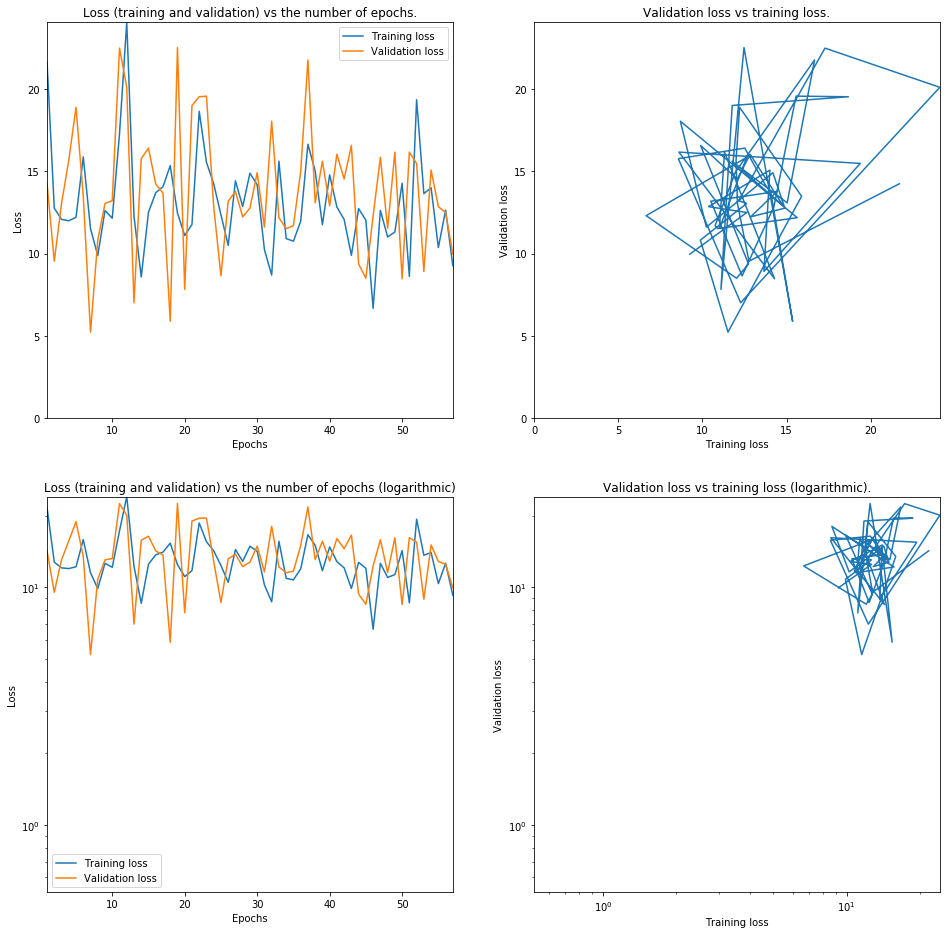

Amount of data 1000 Learning rate: 1.0 Amount of epochs: 37 Final loss: 12.614728817686744


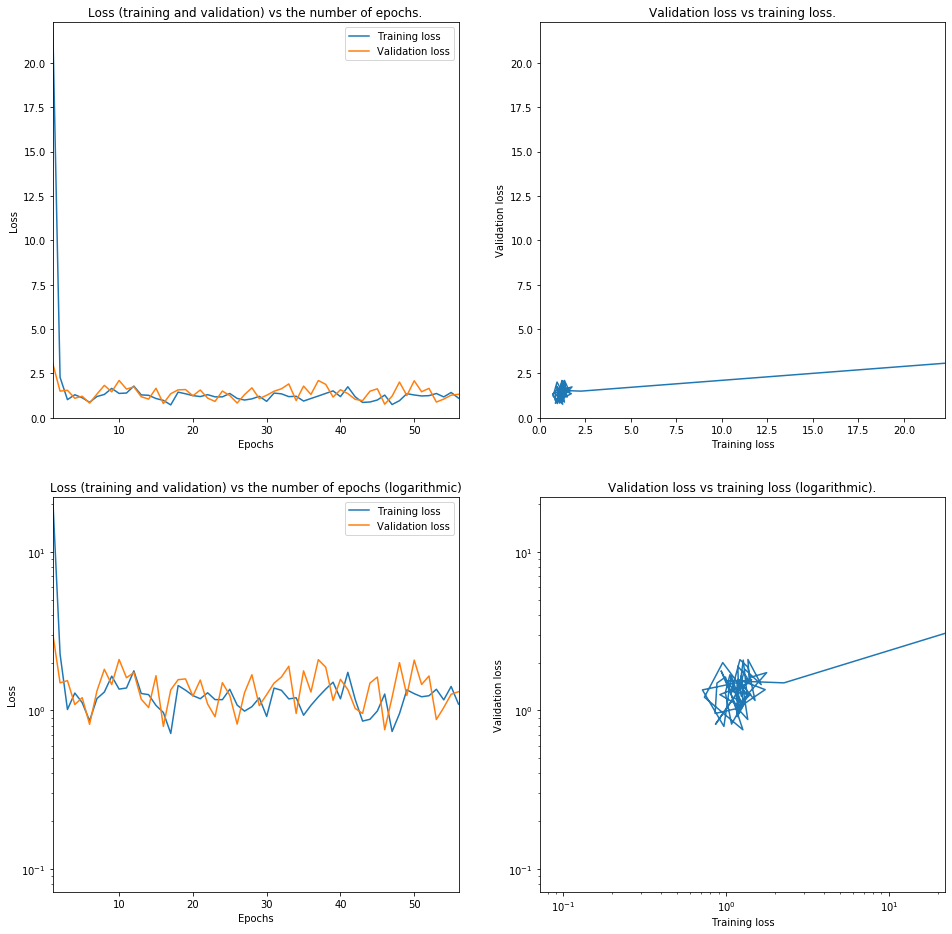

Amount of data 1000 Learning rate: 0.1 Amount of epochs: 24 Final loss: 1.2750034436109114


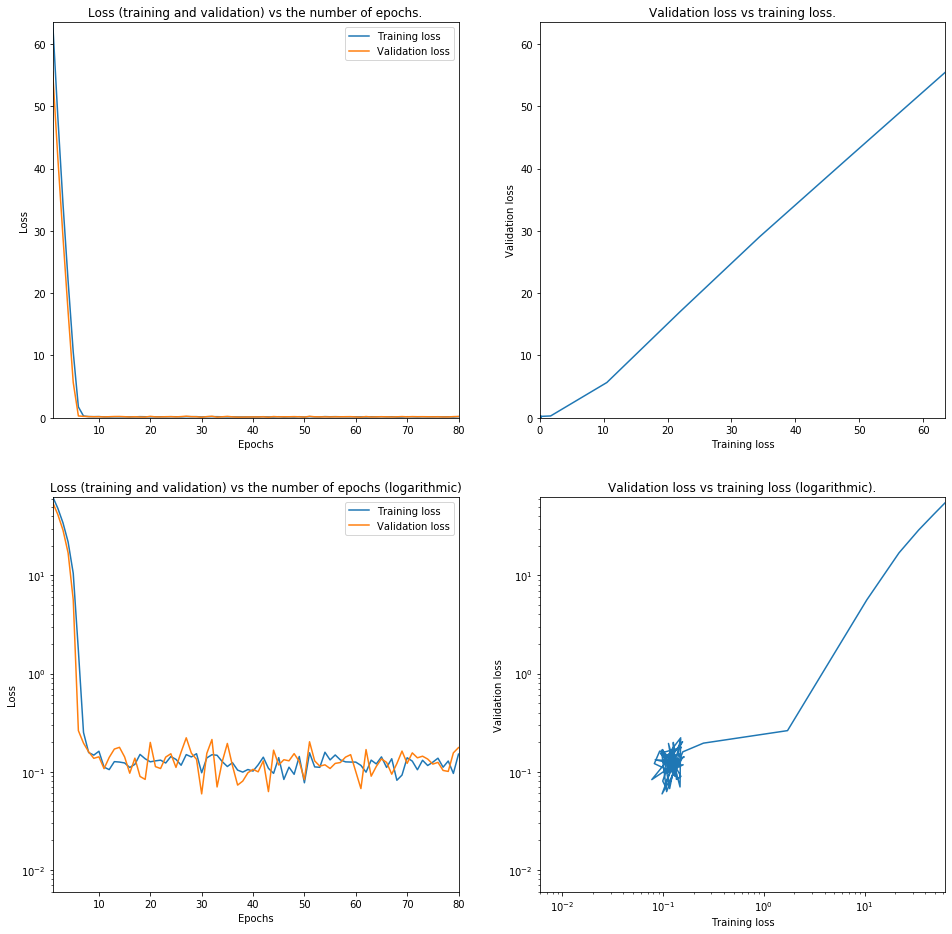

Amount of data 1000 Learning rate: 0.01 Amount of epochs: 17 Final loss: 0.12365390040639306


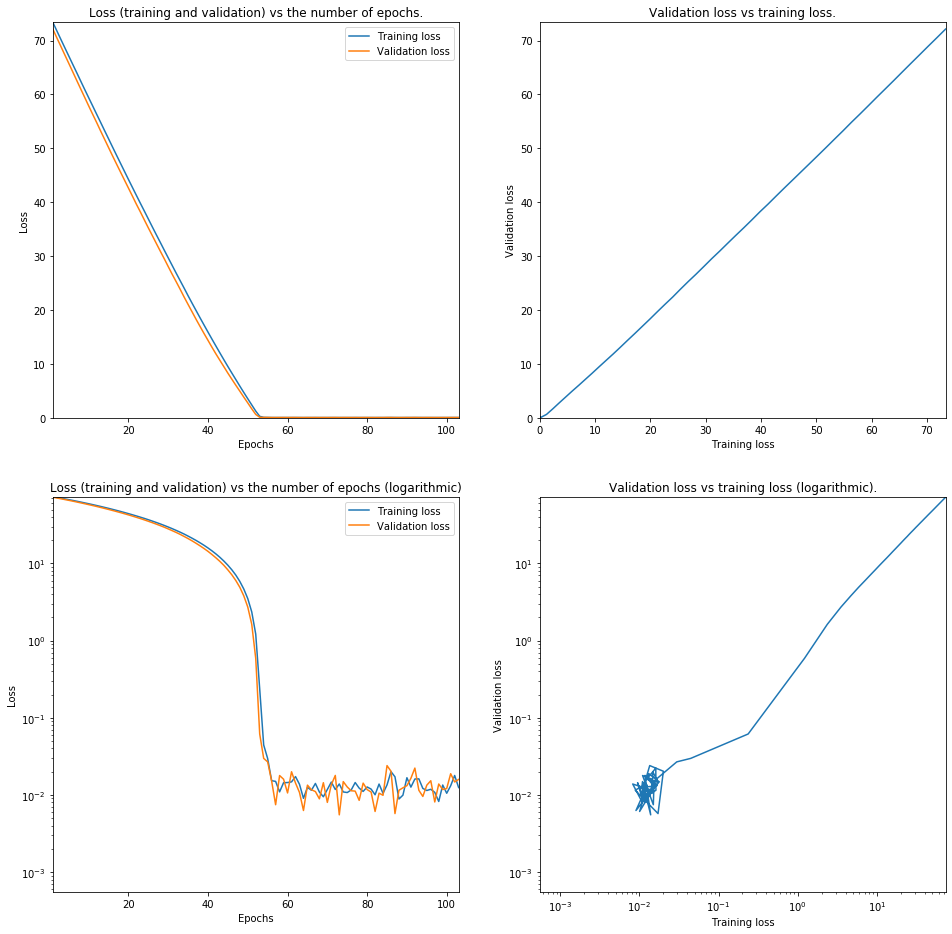

Amount of data 1000 Learning rate: 0.001 Amount of epochs: 48 Final loss: 0.01329150264938267


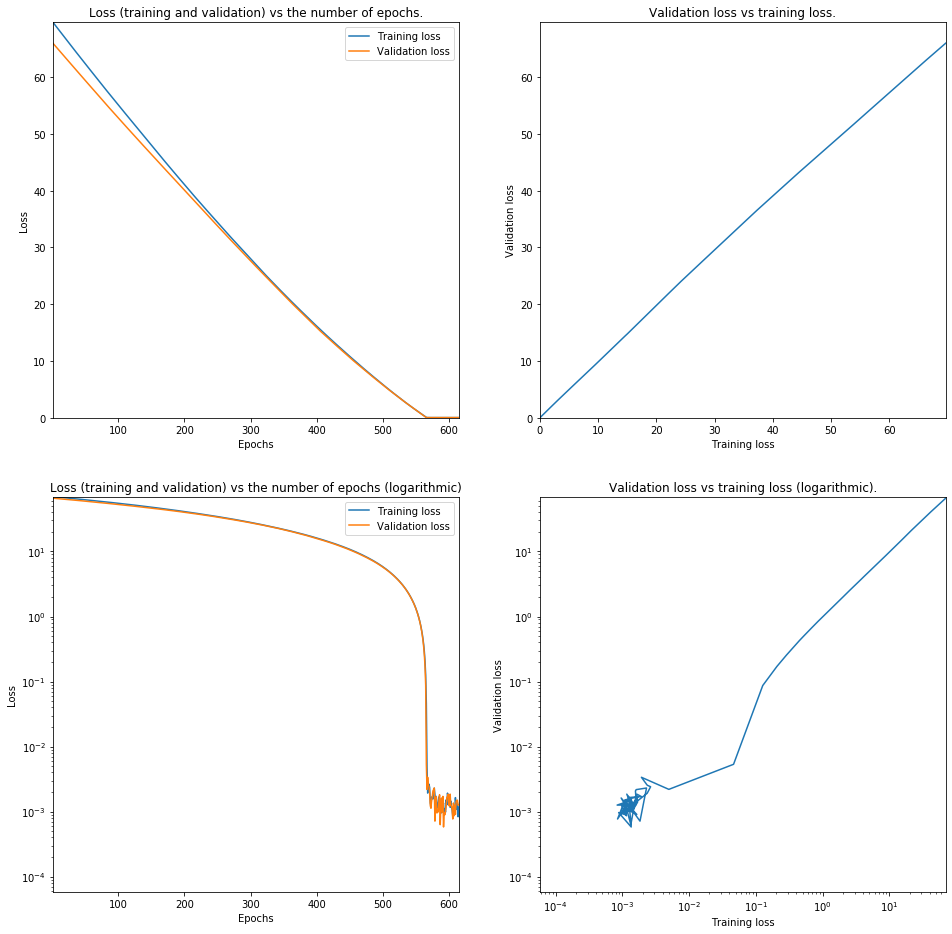

Amount of data 1000 Learning rate: 0.0001 Amount of epochs: 502 Final loss: 0.001517065511192797


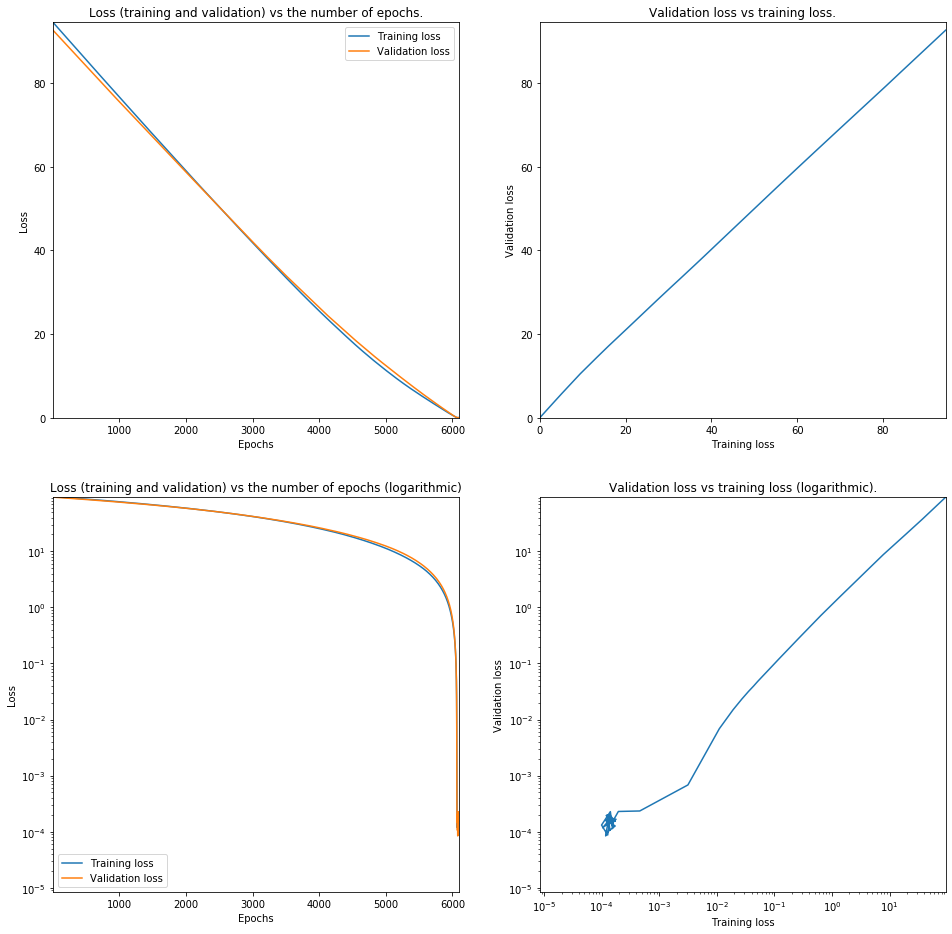

Amount of data 1000 Learning rate: 1e-05 Amount of epochs: 6002 Final loss: 0.015483662652345943


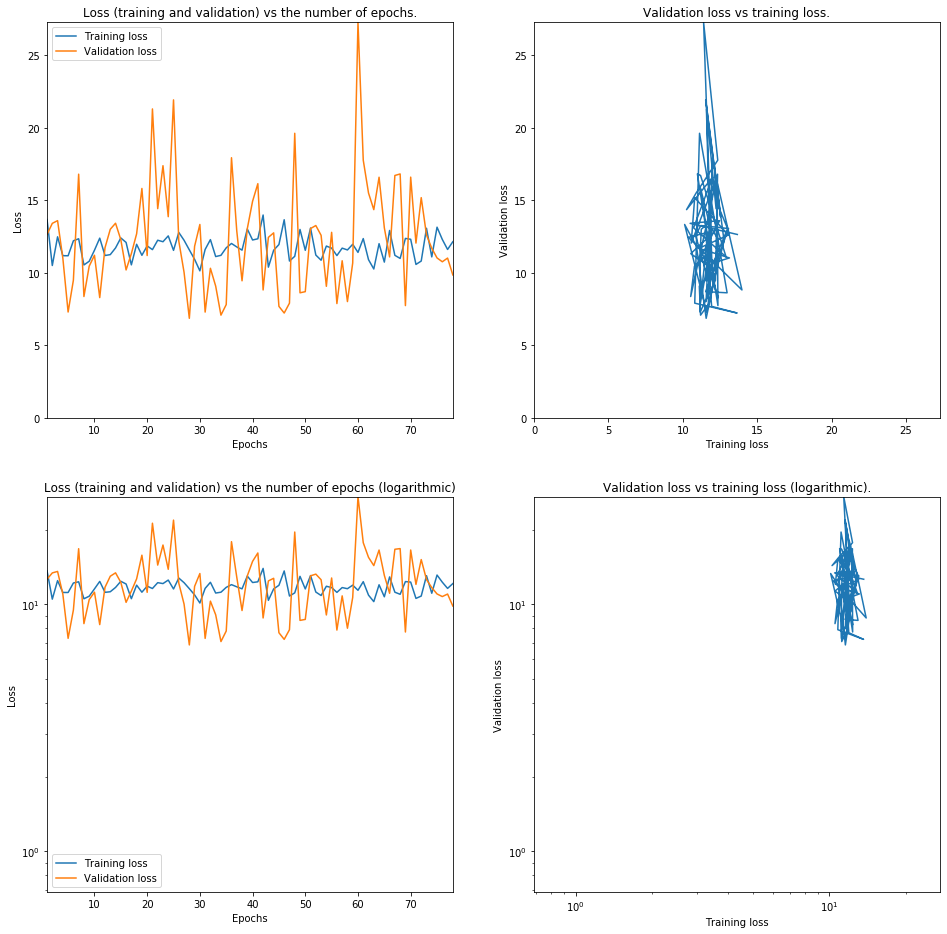

Amount of data 10000 Learning rate: 1.0 Amount of epochs: 79 Final loss: 11.793995090596205


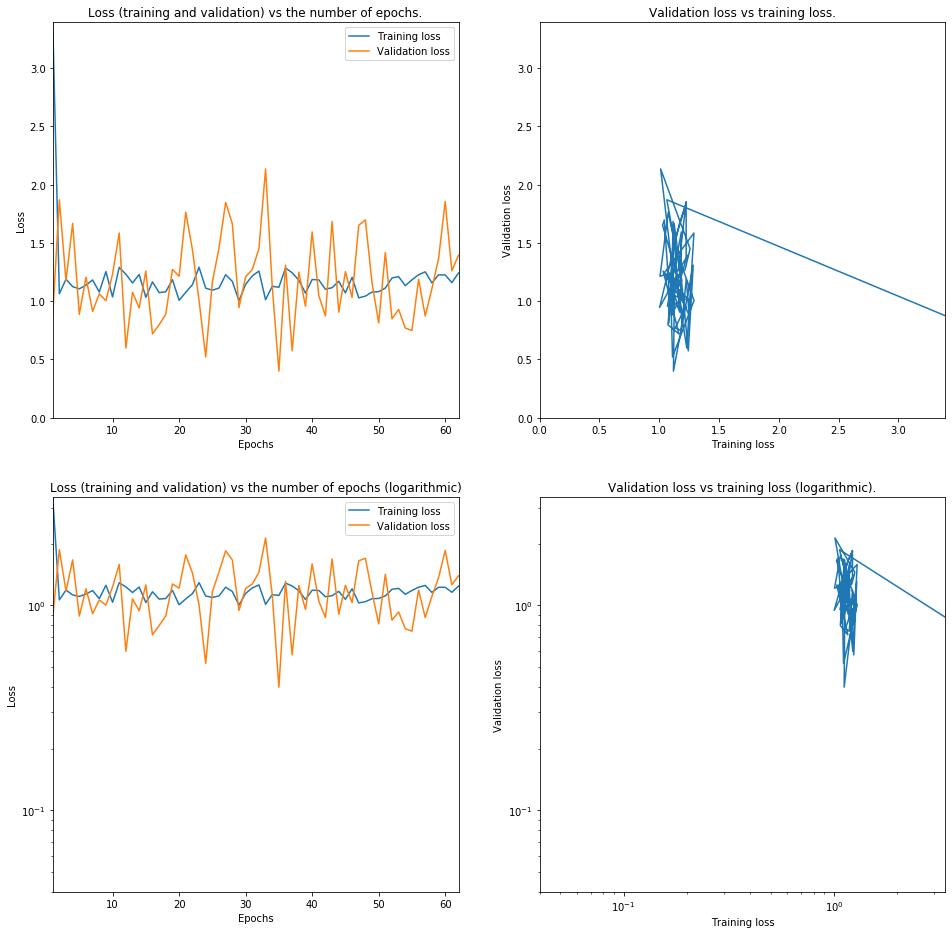

Amount of data 10000 Learning rate: 0.1 Amount of epochs: 7 Final loss: 1.1665358837153637


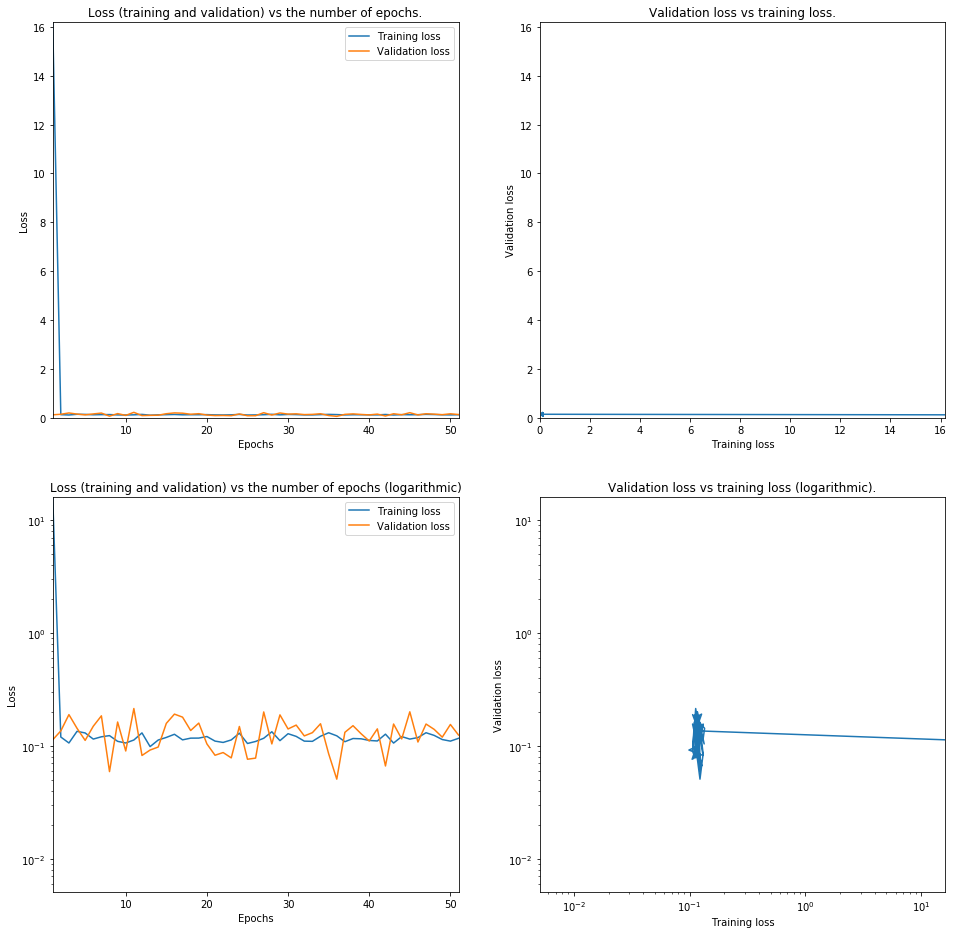

Amount of data 10000 Learning rate: 0.01 Amount of epochs: 1 Final loss: 0.11613241987082423


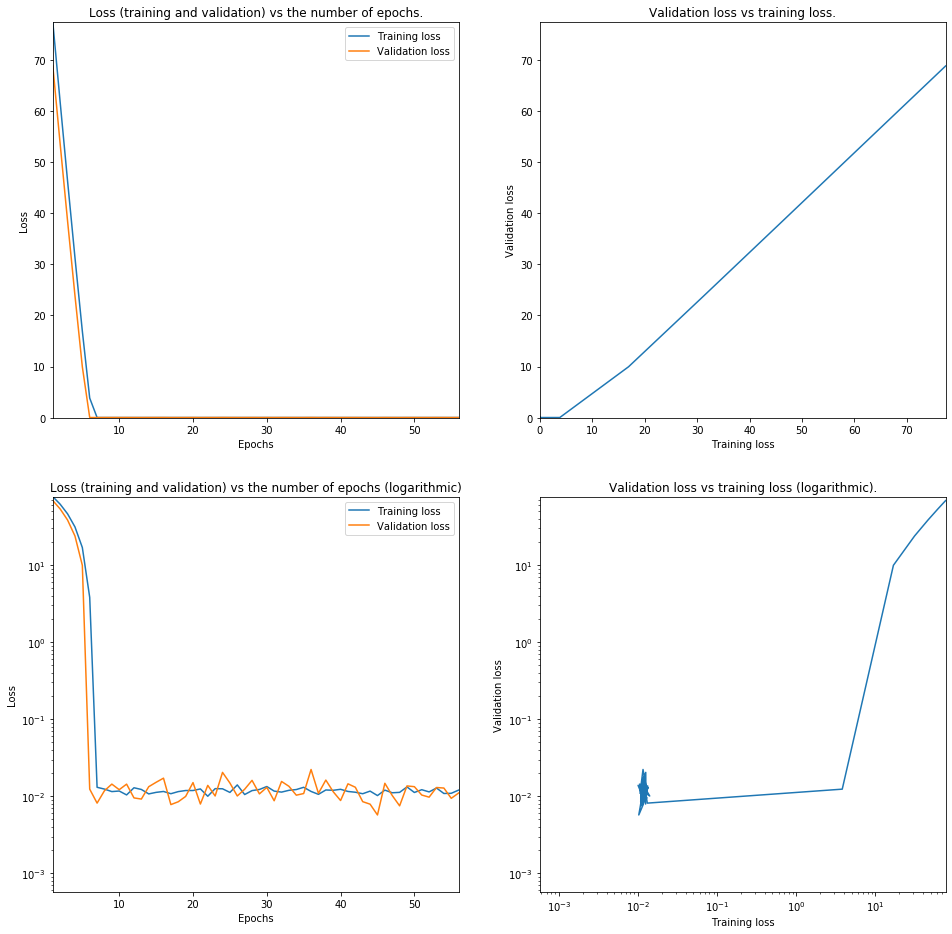

Amount of data 10000 Learning rate: 0.001 Amount of epochs: 6 Final loss: 0.011737147679337027


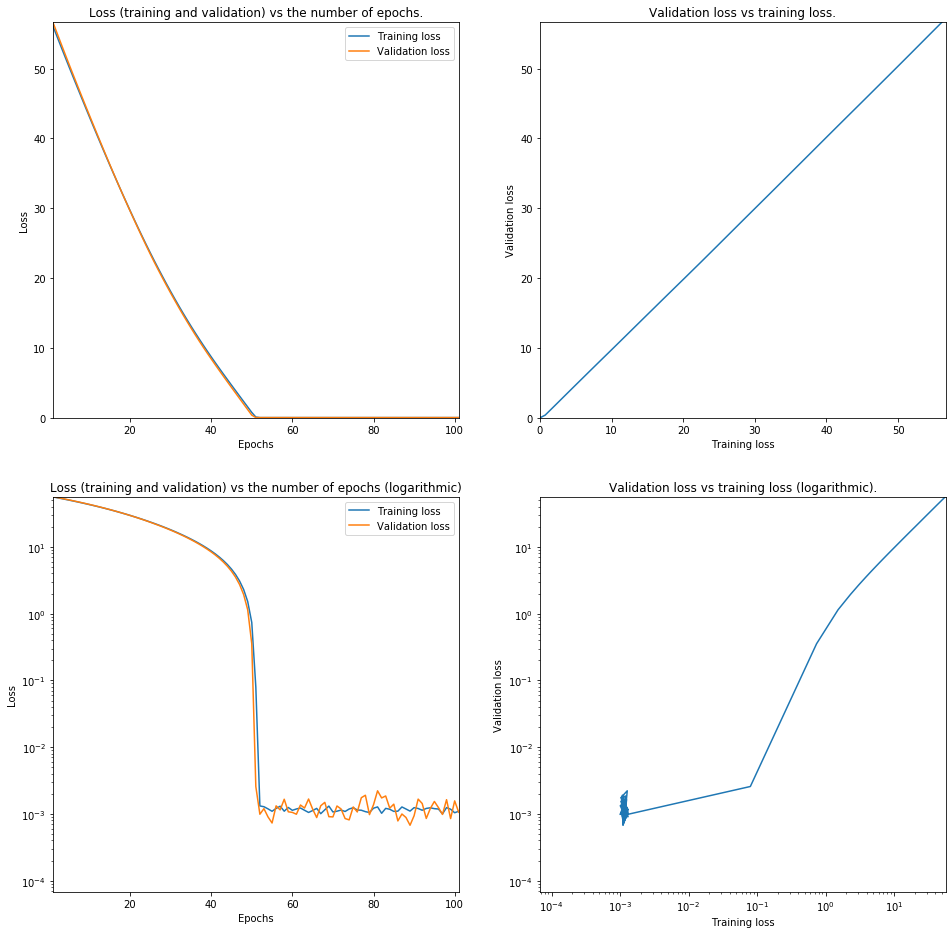

Amount of data 10000 Learning rate: 0.0001 Amount of epochs: 56 Final loss: 0.0011537605659047863


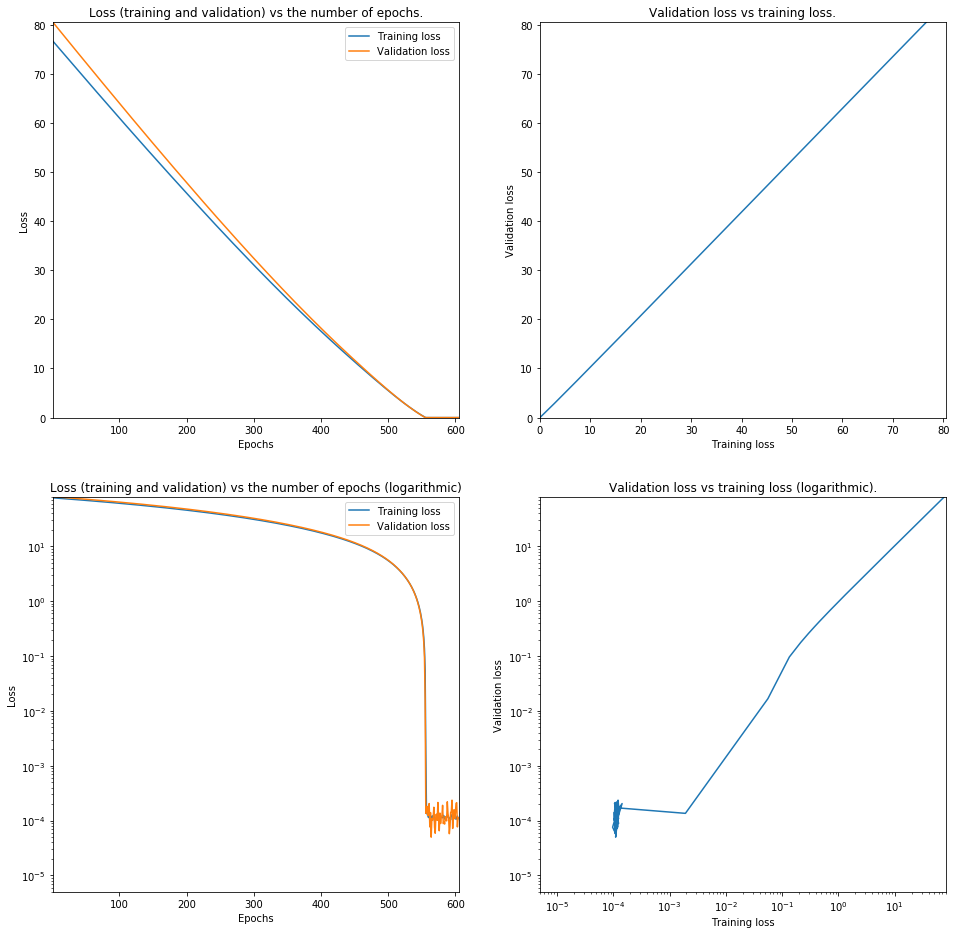

Amount of data 10000 Learning rate: 1e-05 Amount of epochs: 566 Final loss: 0.0003971497945775766


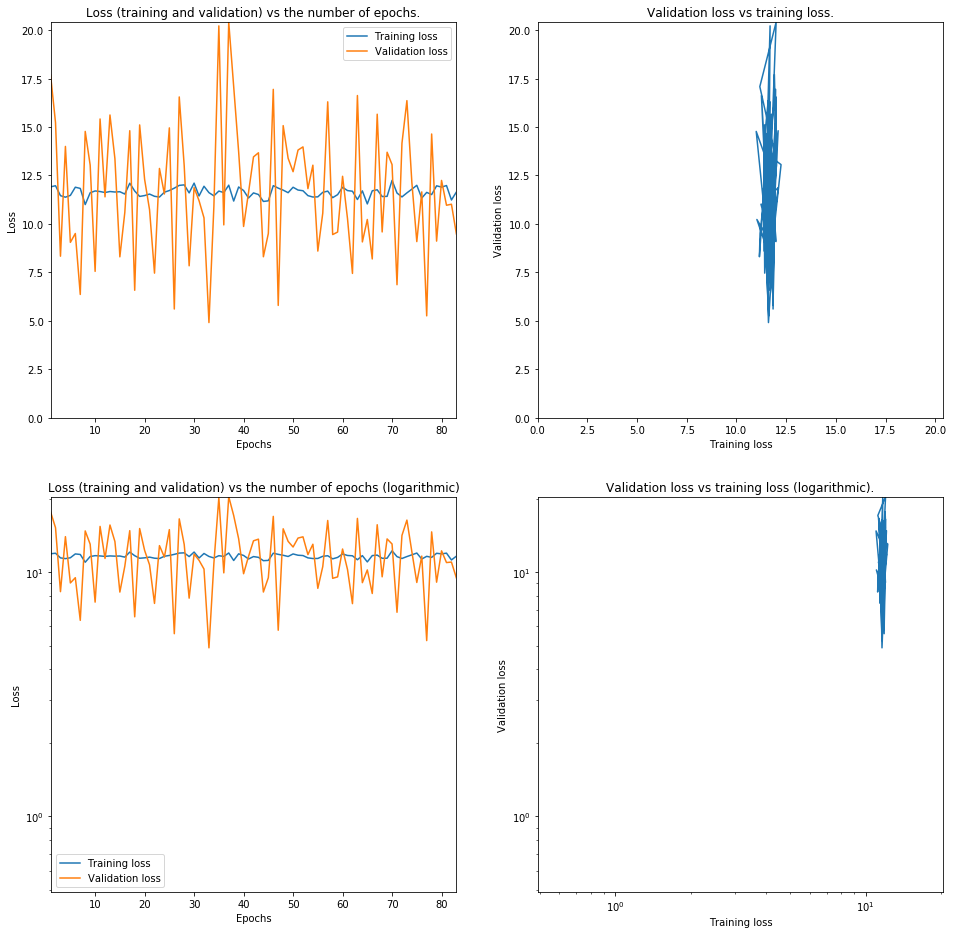

Amount of data 100000 Learning rate: 1.0 Amount of epochs: 21 Final loss: 11.632433554423324


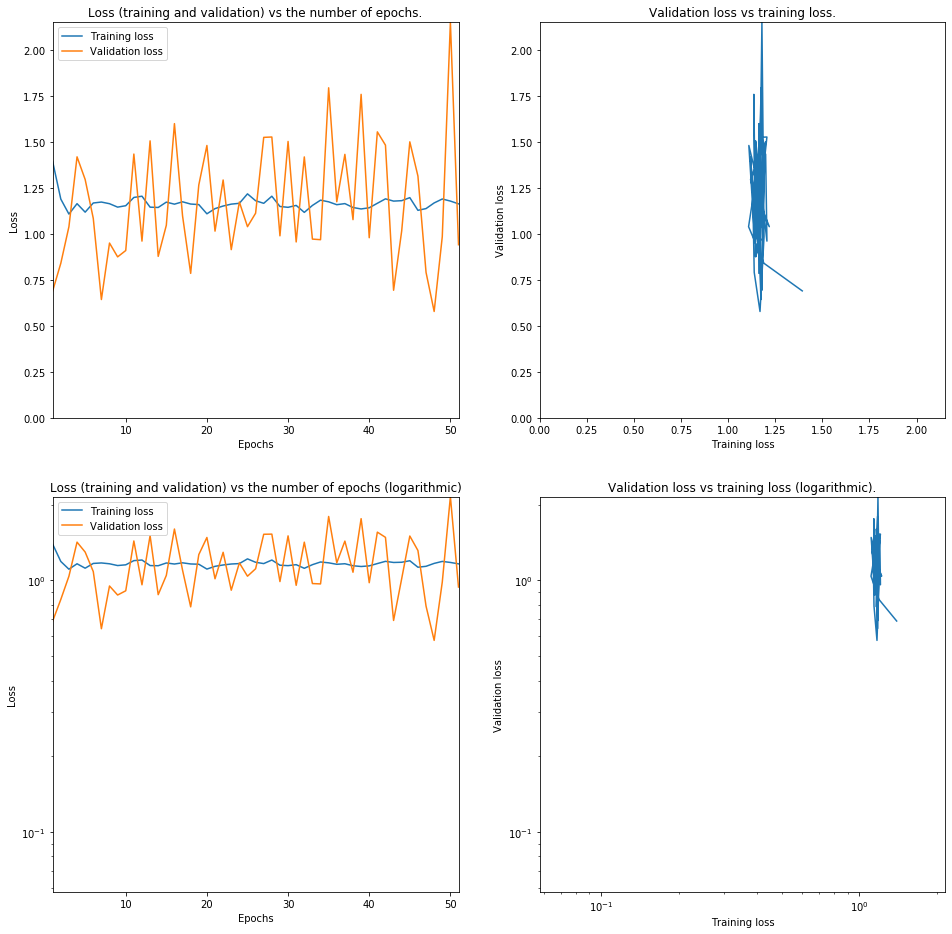

Amount of data 100000 Learning rate: 0.1 Amount of epochs: 2 Final loss: 1.1594471370895867


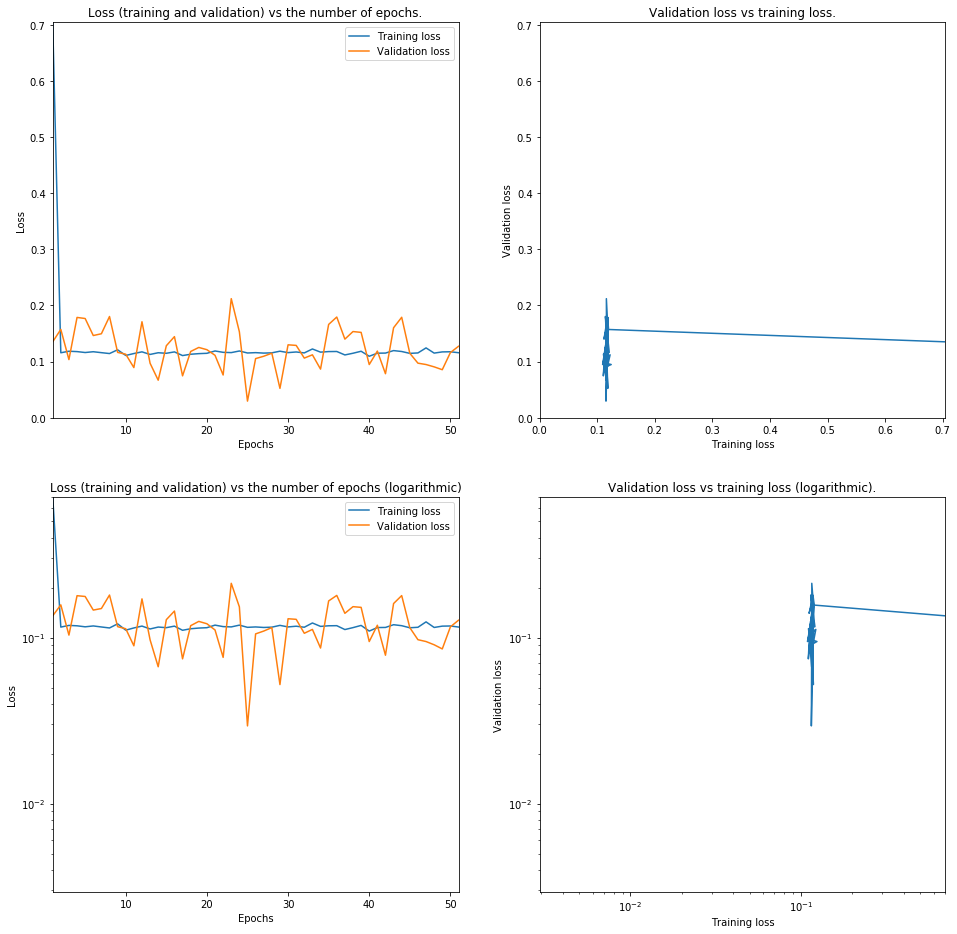

Amount of data 100000 Learning rate: 0.01 Amount of epochs: 1 Final loss: 0.11644220722529353


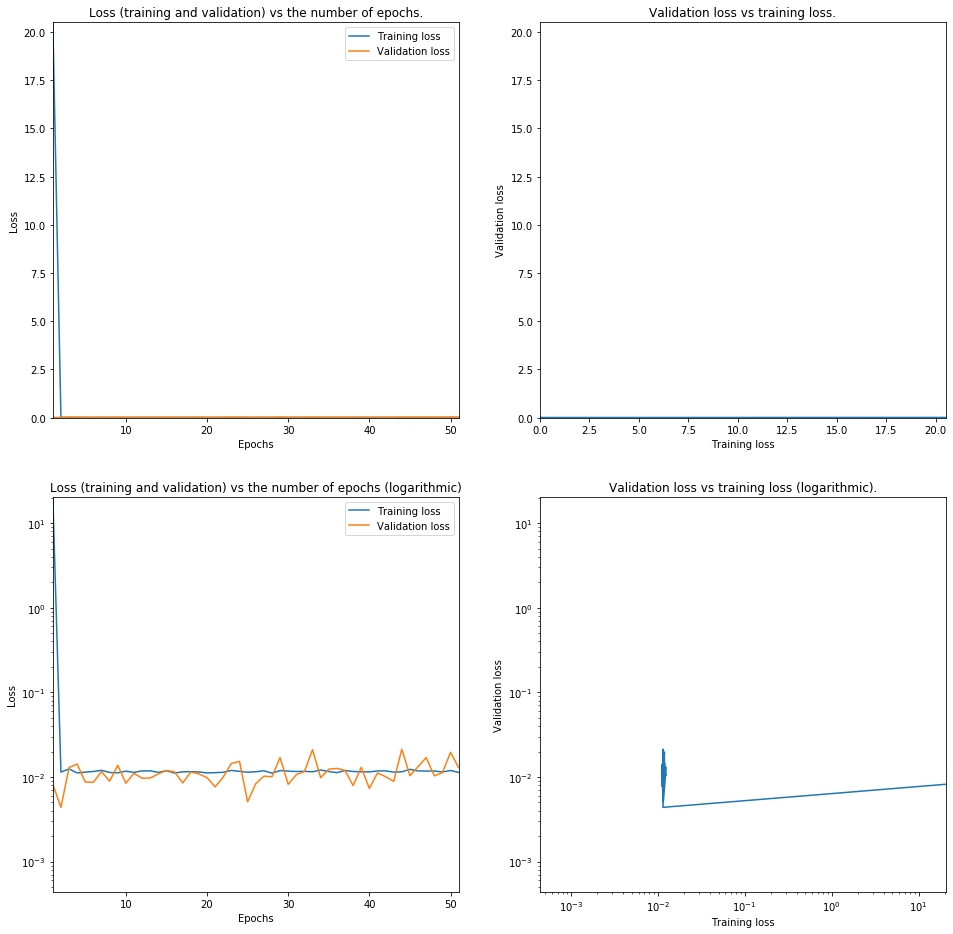

Amount of data 100000 Learning rate: 0.001 Amount of epochs: 1 Final loss: 0.011600493487371575


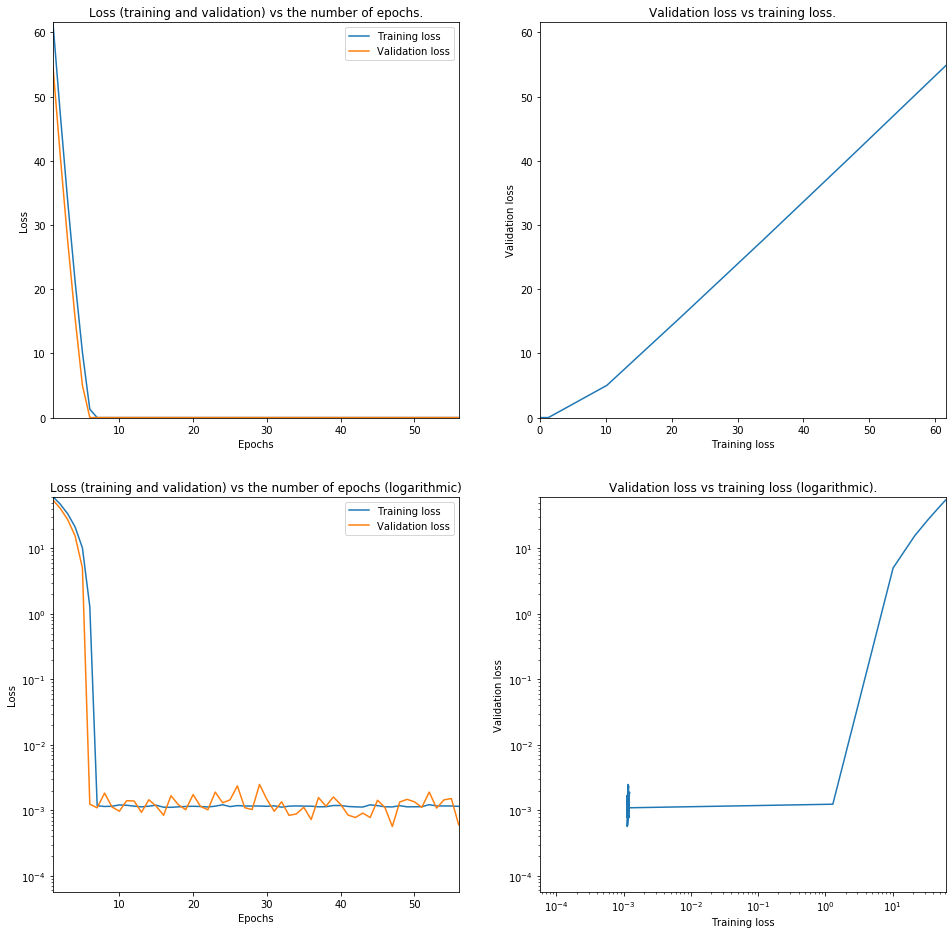

Amount of data 100000 Learning rate: 0.0001 Amount of epochs: 6 Final loss: 0.0011622986403682274


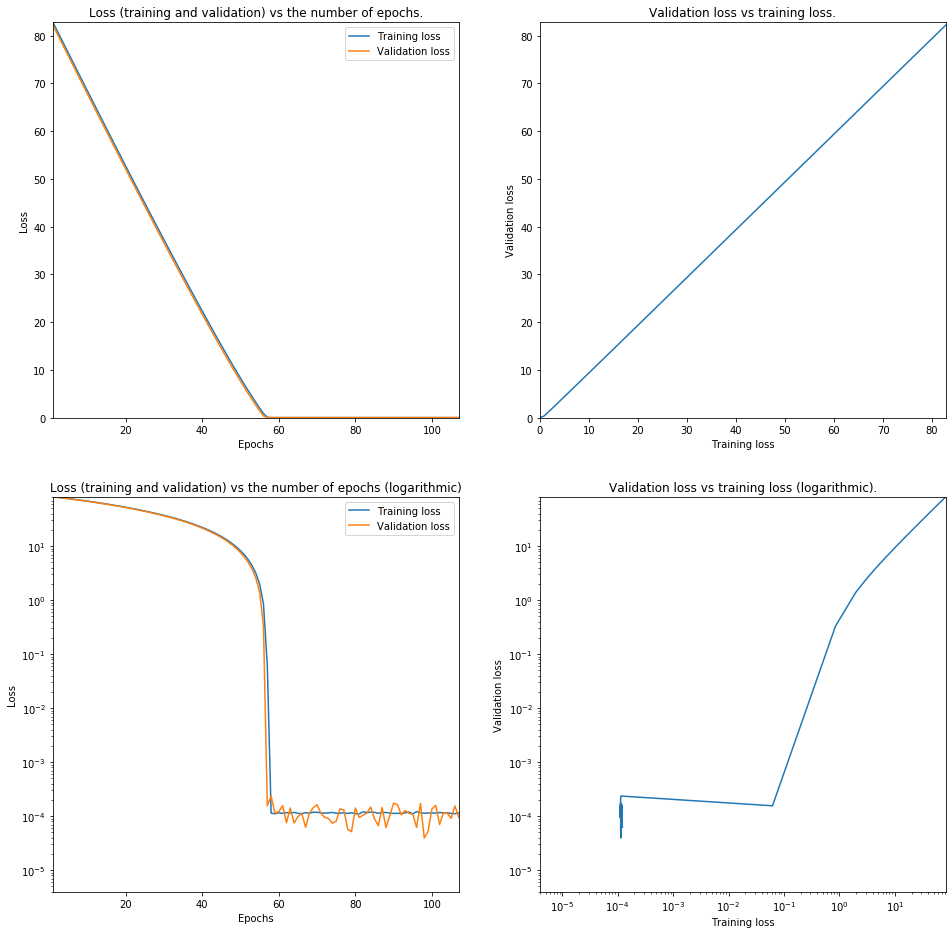

Amount of data 100000 Learning rate: 1e-05 Amount of epochs: 52 Final loss: 0.00011541194114489575


In [662]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]

maxEpochs = 10000

learningRate = []
amountOfData = []

repeat = 3
resulutionOfData = 3
resulutionOfLearning = 6

results = {'amountOfEpochs':[], 'finalLoss':[]}
for i in np.logspace(3, 5, resulutionOfData):
    i = math.ceil(i)
    amountOfData.append(i)
    
    resultsEpochs = []
    resultsLoss = []
    
    learningRateTemp = []
    
    for j in np.logspace(0, -5, resulutionOfLearning):
        learningRateTemp.append(j)
        
        resultsLossTemp = []
        resultsEpochsTemp = []
        
        
        for re in range(repeat):
            dataPointsX, dataPointsY = makeRandomNumberDatabaseSum(math.ceil(i/0.9), 8, 10*5)
            model = makeDenseNetwork(8, settingsLineaerNet, j, kernalInitializer='he_uniform', lossFunction=MAE)
            earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)
            fitDetails = model.fit(dataPointsX, dataPointsY, epochs=maxEpochs, validation_split=0.1, verbose=0, callbacks=[earlyStop])
            loss = fitDetails.history['loss']
            resultsEpochsTemp.append(len(fitDetails.history['loss'])-50)
            resultsLossTemp.append(np.mean([loss[-k] for k in range(1, 50)]))
            
            
        history = plotHistory(fitDetails)
        resultsEpochs.append(math.ceil(np.mean(resultsEpochsTemp)))
        resultsLoss.append(np.mean(resultsLossTemp))
        
        print('Amount of data', math.ceil(i), 'Learning rate:', j, 'Amount of epochs:', resultsEpochs[-1], 'Final loss:', resultsLoss[-1])
    
    results['amountOfEpochs'].append(resultsEpochs)
    results['finalLoss'].append(resultsLoss)
    learningRate.append(learningRateTemp)



Dataset of size 1000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[37, 24, 17, 48, 502, 6002]
[12.614728817686744, 1.2750034436109114, 0.12365390040639306, 0.01329150264938267, 0.001517065511192797, 0.015483662652345943]


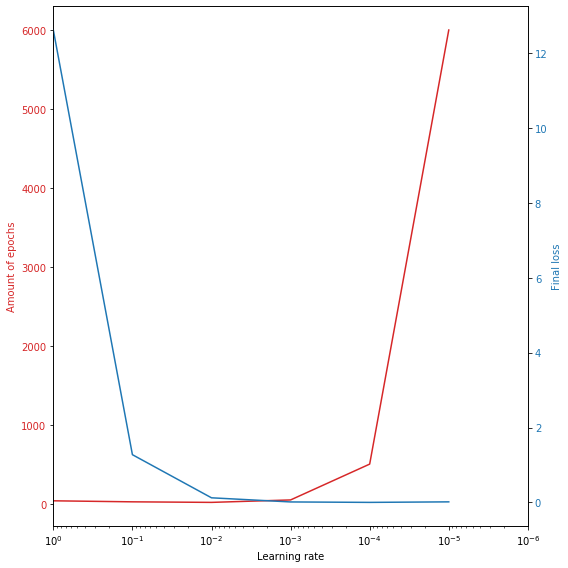

Dataset of size 10000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[79, 7, 1, 6, 56, 566]
[11.793995090596205, 1.1665358837153637, 0.11613241987082423, 0.011737147679337027, 0.0011537605659047863, 0.0003971497945775766]


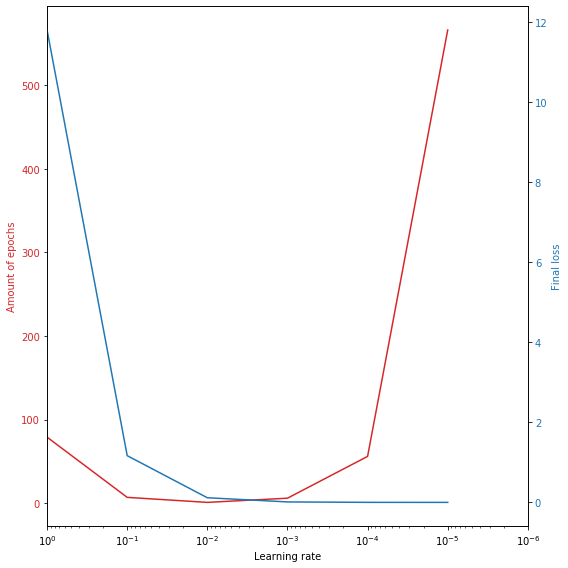

Dataset of size 100000
[1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05]
[21, 2, 1, 1, 6, 52]
[11.632433554423324, 1.1594471370895867, 0.11644220722529353, 0.011600493487371575, 0.0011622986403682274, 0.00011541194114489575]


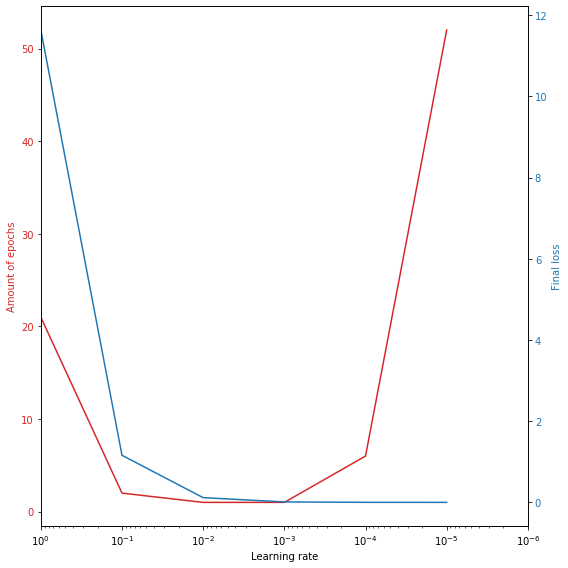

In [664]:
selection=1

for i in range(0, len(amountOfData)):
    print('Dataset of size', amountOfData[i])
    print(learningRate[i])
    print(results['amountOfEpochs'][i])
    print(results['finalLoss'][i])
    fig, ax1 = plt.subplots(figsize=(8, 8))
    color = 'tab:red'
    ax1.set_xlabel('Learning rate')
    ax1.set_xscale('log')
    ax1.set_xlim(10**0, 10**-6)
    ax1.set_ylabel('Amount of epochs', color=color)
    ax1.plot(learningRate[i], results['amountOfEpochs'][i], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Final loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(learningRate[i], results['finalLoss'][i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Model 1: 1 Dense layer

In [ ]:
name = 'LinearNetwork'
settings = [['Dense', 128, False],['Dense', 1, 'linear', False]]


learningRate = 1*10**-5

#model = makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform')#, lossFunction=lossMetric)#eras.initializers.glorot_uniform(seed=None)
model = Sequential()
opt = adam(lr=learningRate)
model.add(Dense(128, activation="relu", use_bias=False, input_dim=8))
model.add(Dense(1, activation="linear", use_bias=False))
model.compile(loss=MAE, optimizer=opt)

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())
    #print(model.evaluate(validationInput['input'], validationInput['target'], verbose=0))

In [ ]:
fitDetails = model.fit(X, y, epochs=30, validation_split=0.3, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)
#fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=30, verbose=1)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

In [ ]:
model.layers[0].set_weights([np.array([[1] for i in range(8)])])
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

model.evaluate(X, y)

# Finishing

In [ ]:

#print(evaluation)

y = [[],[]]
for i in range(len(x)):
    y[0].append(model.predict([[testData['eigenvalues'][i]]])[0][0])
    y[1].append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y[0], label='Predicted potential energy')
ax1.plot(list(x), y[1], label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
plt.show()

"""
makePredictionPlot(model, validationData)

for i in validationPlots:
    plotAndPredict(model, validationData, i)
"""
#"""
print(model.summary())
for layer in model.layers:
    print(layer.get_weights())
#"""
print()


In [ ]:
for i in range(len(models)):
    model = models[i]['model']
    print(models[i]['name'])
    print(model.summary())
    print(models[i]['evaluation'])
    model.save(saveFolder + '/' + models[i]['name'] + str(models[i]['evaluation']) + '.h5')
    print('\n \n')

#model = models[1][0]
#model.save('model1.h5')
#model = load_model('model1.h5')

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)